### Definitions, imports, and settings

In [4]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patches, colors, cm
from astropy.table import Table
from scipy.stats import norm
from scipy.optimize import curve_fit

# Plot settings
plt.rc(('xtick', 'ytick'), direction='in')
plt.rc('xtick', top=True)
plt.rc('ytick', right=True)
plt.rc('font', family='STIXgeneral')
plt.rc('figure', dpi=140)

# Paths
data_dir = '/users/PAS2055/lodubay/Data/APOGEE'
data_path = Path(data_dir)
apokasc_file = 'APOKASC_cat_v6.7.2.fits'
starhorse_file = 'APOGEE_DR17_EDR3_STARHORSE_v2.fits'
astroNN_file = 'apogee_astroNN-DR17.fits'

def decode(df):
    """
    Decode DataFrame with byte strings into ordinary strings.

    """
    str_df = df.select_dtypes([object])
    str_df = str_df.stack().str.decode('utf-8').unstack()
    for col in str_df:
        df[col] = str_df[col]
    return df

def rms(array, arrmin=None, arrmax=None, axis=None):
    """
    Return the root-mean-square of a given array

    """
    if arrmin:
        array = array[array > arrmin]
    if arrmax:
        array = array[array < arrmax]
    return np.sqrt(np.mean(array**2, axis=axis))

def quad_add(arr1, arr2):
    """
    Add input arrays in quadrature.
    
    """
    return np.sqrt(arr1**2 + arr2**2)

### Import and combine data

In [36]:
# APOKASC catalog
print('Importing APOKASC catalog...')
data = Table.read(data_path / apokasc_file, format='fits')
apokasc_df = decode(data.to_pandas())
# apokasc_df['LOC_ID'] = apokasc_df['LOC_ID'].astype(int)
# Relevant columns
apokasc_cols = ['2MASS_ID', #'LOC_ID', 
                'APOKASC2_AGE', 'APOKASC2_AGE_MERR', 
                'APOKASC2_AGE_PERR', 'DR16_ALP_M_COR', 'DR16_ALP_M_COR_ERR', 
                'DR16_FE_H', 'DR16_FE_H_ERR', 'DR16_M_H_COR', 
                'DR16_M_H_COR_ERR', 'DR16_O_FE', 'DR16_O_FE_ERR']

# astroNN DR17 catalog
print('Importing astroNN DR17 catalog...')
data = Table.read(data_path / astroNN_file, format='fits')
astroNN_df = decode(data.to_pandas())
astroNN_cols = ['APOGEE_ID', #'LOCATION_ID', 
                'age_lowess_correct', 'age_total_error',
                'TEFF', 'TEFF_ERR', 'LOGG', 'LOGG_ERR', 'C_H', 'C_H_ERR', 
                'N_H', 'N_H_ERR', 'O_H', 'O_H_ERR', 'TI_H', 'TI_H_ERR', 'FE_H', 'FE_H_ERR']

# StarHorse DR17 catalog
print('Importing StarHorse DR17 catalog...')
data = Table.read(data_path / starhorse_file, format='fits')
starhorse_df = decode(data.to_pandas())
starhorse_cols = ['APOGEE_ID', 'met16', 'met50', 'met84']

# Consolidate into single DataFrame
print('Combining datasets...')
stellar_params = apokasc_df[apokasc_cols].rename(columns={'2MASS_ID': 'APOGEE_ID'})#, 'LOC_ID': 'LOCATION_ID'})
# stellar_params = stellar_params.join(astroNN_df[astroNN_cols].set_index(['APOGEE_ID', 'LOCATION_ID']), 
#                                      on=['APOGEE_ID', 'LOCATION_ID'], how='outer', rsuffix='_astroNN')
stellar_params = stellar_params.join(astroNN_df[astroNN_cols].set_index('APOGEE_ID'), 
                                     on='APOGEE_ID', how='outer', rsuffix='_astroNN')
stellar_params = stellar_params.join(starhorse_df[starhorse_cols].set_index('APOGEE_ID'), 
                                     on='APOGEE_ID', how='outer', rsuffix='_StarHorse')
# Clean up
stellar_params.replace([np.inf, -np.inf, -9999., -9999.99, -999., -999.99], np.nan, inplace=True)
stellar_params.dropna(how='all', inplace=True)
# TODO better way to deal with astroNN duplicates (same APOGEE_ID, different LOCATION_ID)
stellar_params.drop_duplicates(subset='APOGEE_ID', inplace=True)
stellar_params.set_index('APOGEE_ID', inplace=True)
# Rename columns
mapper = dict([(col, 'ASTRONN_'+col) for col in astroNN_cols[3:]])
stellar_params.rename(columns=mapper, inplace=True)
stellar_params.rename(columns={'age_lowess_correct': 'ASTRONN_AGE', 'age_total_error': 'ASTRONN_AGE_ERR', 'met50': 'STARHORSE_M_H'}, 
                      inplace=True)
# Combine columns
stellar_params['STARHORSE_M_H_MERR'] = stellar_params['STARHORSE_M_H'] - stellar_params['met16']
stellar_params['STARHORSE_M_H_PERR'] = stellar_params['met84'] - stellar_params['STARHORSE_M_H']
stellar_params.drop(['met16', 'met84'], axis='columns', inplace=True)
stellar_params['ASTRONN_C_N'] = stellar_params['ASTRONN_C_H'] - stellar_params['ASTRONN_N_H']
stellar_params['ASTRONN_C_N_ERR'] = quad_add(stellar_params['ASTRONN_C_H_ERR'], stellar_params['ASTRONN_N_H_ERR'])
stellar_params['ASTRONN_O_FE'] = stellar_params['ASTRONN_O_H'] - stellar_params['ASTRONN_FE_H']
stellar_params['ASTRONN_O_FE_ERR'] = quad_add(stellar_params['ASTRONN_O_H_ERR'], stellar_params['ASTRONN_FE_H_ERR'])
print('Done!')
print(stellar_params)

Importing APOKASC catalog...
Importing astroNN DR17 catalog...
Importing StarHorse DR17 catalog...
Combining datasets...
Done!
                     APOKASC2_AGE  APOKASC2_AGE_MERR  APOKASC2_AGE_PERR  \
APOGEE_ID                                                                 
2M19051857+4654038            NaN                NaN                NaN   
2M19052050+4655041            NaN                NaN                NaN   
2M19052775+4658526            NaN                NaN                NaN   
2M19052985+4654372       8.413952           1.085706           1.291148   
2M19061343+4657264            NaN                NaN                NaN   
...                           ...                ...                ...   
2M23595886+5726058            NaN                NaN                NaN   
2M23595921+5609479            NaN                NaN                NaN   
2M23595949-7342592            NaN                NaN                NaN   
2M23595980+1528407            NaN               

In [15]:
### Looking into duplicates

# print(stellar_params[pd.isna(stellar_params['LOCATION_ID'])].shape)
print(stellar_params.drop_duplicates().shape)

idx = stellar_params.index
print(idx.drop_duplicates().shape)

# dups = []
# for i, apogee_id in enumerate(idx):
#     if apogee_id in idx[:i]:
#         dups.append(apogee_id)
    
#     if len(dups) > 10:
#         break
# print(dups)
# print(stellar_params.loc[dups[9], ['ASTRONN_AGE', 'ASTRONN_AGE_ERR']])

(643438, 34)
(657136,)


### Age comparison

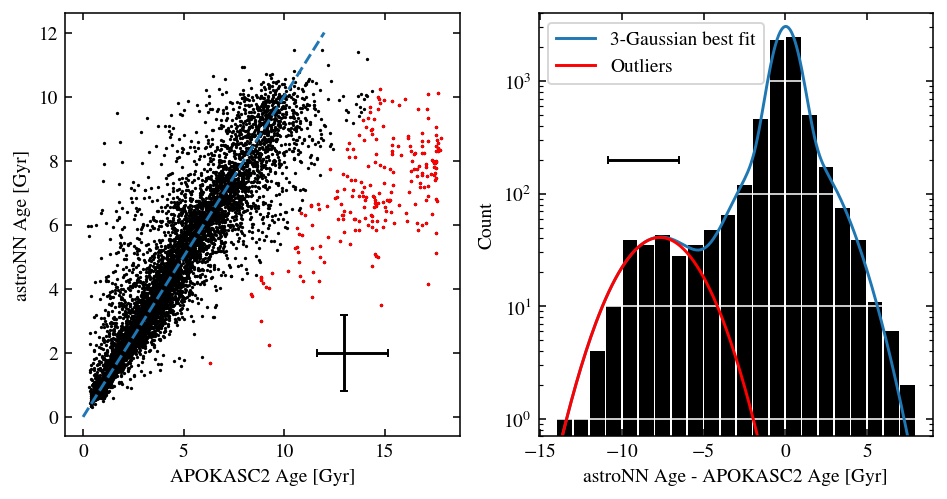

Best fit parameters
sigma1: 0.688124611756609
sigma2: 2.1115427809268073
loc3:  -7.67104634027151
sigma3: 2.0951728777850636
Sample within sigma2: 5831 or 89%


In [5]:
# Select targets with ages from both APOKASC and astroNN
ages = stellar_params[(pd.notna(stellar_params['APOKASC2_AGE'])) & 
                      (pd.notna(stellar_params['ASTRONN_AGE'])) &
                      (pd.notna(stellar_params['APOKASC2_AGE_PERR']))]

age_diff = ages['ASTRONN_AGE'] - ages['APOKASC2_AGE']
age_diff_err = np.array([quad_add(ages['ASTRONN_AGE_ERR'], ages['APOKASC2_AGE_MERR']),
                         quad_add(ages['ASTRONN_AGE_ERR'], ages['APOKASC2_AGE_PERR'])])
rms_diff_err = np.array([rms(age_diff_err, axis=1)]).transpose()

def trimodal_norm(x, loc1, scale1, a1, loc2, scale2, a2, loc3, scale3, a3):
    """Bimodal Gaussian to fit to age difference."""
    return a1 * norm.pdf(x, loc1, scale1) + a2 * norm.pdf(x, loc2, scale2) + a3 * norm.pdf(x, loc3, scale3)

# APOKASC age vs astroNN age
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# Histrogram of age differences
ax = axs[1]
xmin = -14
xmax = 8
bins = np.linspace(xmin, xmax, xmax-xmin+1)
y, x, _ = ax.hist(ages['ASTRONN_AGE'] - ages['APOKASC2_AGE'], 
                  color='k', bins=bins, rwidth=0.9)
x = x[:-1] + (x[1] - x[0])/2
ax.grid(which='major', axis='y', color='w')
# plot RMS error
ax.errorbar(-9, 200, 
            xerr=rms_diff_err, 
            color='k', capsize=2)
# best fit bimodal normal
params, cov = curve_fit(trimodal_norm, x, y, p0=(0, 0.5, 5e3, 0, 2, 1e3, -9, 2, 40))
x_fine = np.arange(xmin, xmax, 0.1)
ax.plot(x_fine, trimodal_norm(x_fine, *params), label='3-Gaussian best fit')
# individual distributions
# ax.plot(x_fine, params[2] * norm.pdf(x_fine, *params[0:2]))
# ax.plot(x_fine, params[5] * norm.pdf(x_fine, *params[3:5]))
ax.plot(x_fine, params[8] * norm.pdf(x_fine, *params[6:8]), c='r', label='Outliers')
# plot settings
ax.set_yscale('log')
ax.set_xlabel('astroNN Age - APOKASC2 Age [Gyr]')
ax.set_ylabel('Count')
ax.set_ylim((7e-1, 4e3))
plt.legend()

def prob_outlier(x):
    p_center = params[2] * norm.pdf(x, *params[0:2]) + params[5] * norm.pdf(x, *params[3:5])
    p_out = params[8] * norm.pdf(x, *params[6:8])
    return p_out / p_center

# Scatter plot of ages
ax = axs[0]
ax.plot([0, 12], [0, 12], linestyle='--')
ax.scatter(ages['APOKASC2_AGE'], ages['ASTRONN_AGE'], s=0.5, c='k')
outliers = ages[prob_outlier(age_diff) > 0.5]
ax.scatter(outliers['APOKASC2_AGE'], outliers['ASTRONN_AGE'], s=0.6, c='r')
# plot RMS error
ax.errorbar(13, 2, 
            xerr=[[rms(ages['APOKASC2_AGE_MERR'])],
                  [rms(ages['APOKASC2_AGE_PERR'])]], 
            yerr=rms(ages['ASTRONN_AGE_ERR']),
            color='k', capsize=2)
ax.set_xlabel('APOKASC2 Age [Gyr]')
ax.set_ylabel('astroNN Age [Gyr]')
plt.show()

print('Best fit parameters')
print('sigma1:', params[1])
print('sigma2:', params[4])
print('loc3: ', params[6])
print('sigma3:', params[7])
small_diff = age_diff[np.abs(age_diff) < params[4]]
print('Sample within sigma2:', small_diff.size, f'or {small_diff.size/age_diff.size*100:.0f}%')

In [6]:
# List of IDs for stars with big age differences
age_discrep = ages[(ages['ASTRONN_AGE'] - ages['APOKASC2_AGE']) < -5]
age_discrep['AGE_DIFF'] = age_discrep['ASTRONN_AGE'] - age_discrep['APOKASC2_AGE']
age_discrep.to_csv('age_discrep.csv')

/apps/python/3.7-2019.10/lib/python3.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


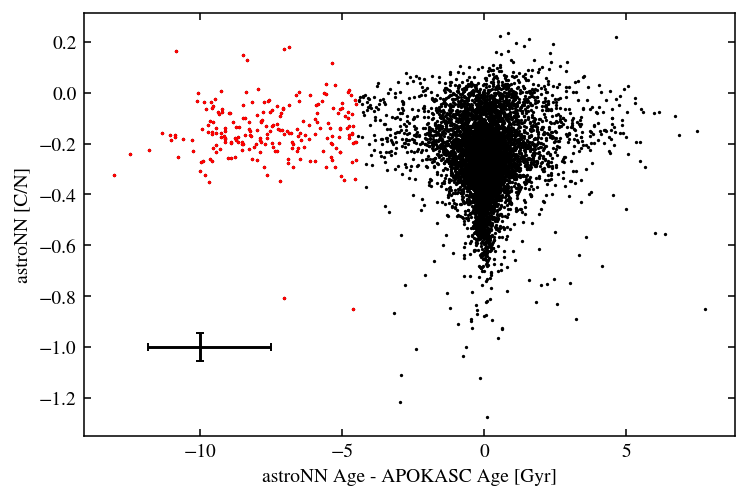

In [11]:
# Age difference vs C/N
fig, ax = plt.subplots()
ax.scatter(ages['ASTRONN_AGE'] - ages['APOKASC2_AGE'], 
           ages['ASTRONN_C_N'], c='k', s=.5)
ax.scatter(outliers['ASTRONN_AGE'] - outliers['APOKASC2_AGE'], 
           outliers['ASTRONN_C_N'], c='r', s=.6)
# plot RMS errors added in quadrature
ax.errorbar(-10, -1, 
            xerr=rms_diff_err,
            yerr=rms(ages['ASTRONN_C_N_ERR']),
            color='k', capsize=2)
ax.set_xlabel('astroNN Age - APOKASC Age [Gyr]')
ax.set_ylabel('astroNN [C/N]')
plt.savefig('agediff_CN.png')
plt.show()

### Alpha abundance comparison

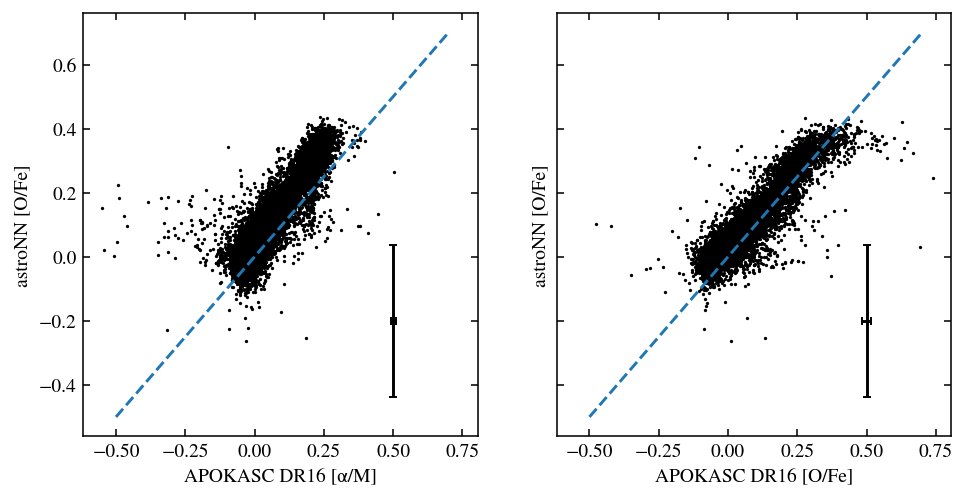

In [12]:
# select targets with alpha (O) abundances from APOKASC and astroNN
alphas = stellar_params[(pd.notna(stellar_params['DR16_ALP_M_COR'])) & (pd.notna(stellar_params['ASTRONN_O_FE']))]

fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax = axs[0]
ax.scatter(alphas['DR16_ALP_M_COR'], alphas['ASTRONN_O_FE'], c='k', s=0.5)
ax.plot([-0.5, 0.7], [-0.5, 0.7], linestyle='--')
ax.errorbar(0.5, -0.2, xerr=rms(alphas['DR16_ALP_M_COR_ERR']), yerr=rms(alphas['ASTRONN_O_FE_ERR']), capsize=2, color='k')
ax.set_xlabel('APOKASC DR16 [α/M]')
ax.set_ylabel('astroNN [O/Fe]')

ax = axs[1]
ax.scatter(alphas['DR16_O_FE'], alphas['ASTRONN_O_FE'], c='k', s=0.5)
ax.plot([-0.5, 0.7], [-0.5, 0.7], linestyle='--')
ax.errorbar(0.5, -0.2, xerr=rms(alphas['DR16_O_FE_ERR']), yerr=rms(alphas['ASTRONN_O_FE_ERR']), capsize=2, color='k')
ax.set_xlabel('APOKASC DR16 [O/Fe]')
ax.set_ylabel('astroNN [O/Fe]')
plt.show()

### Iron abundance / metallicity comparison

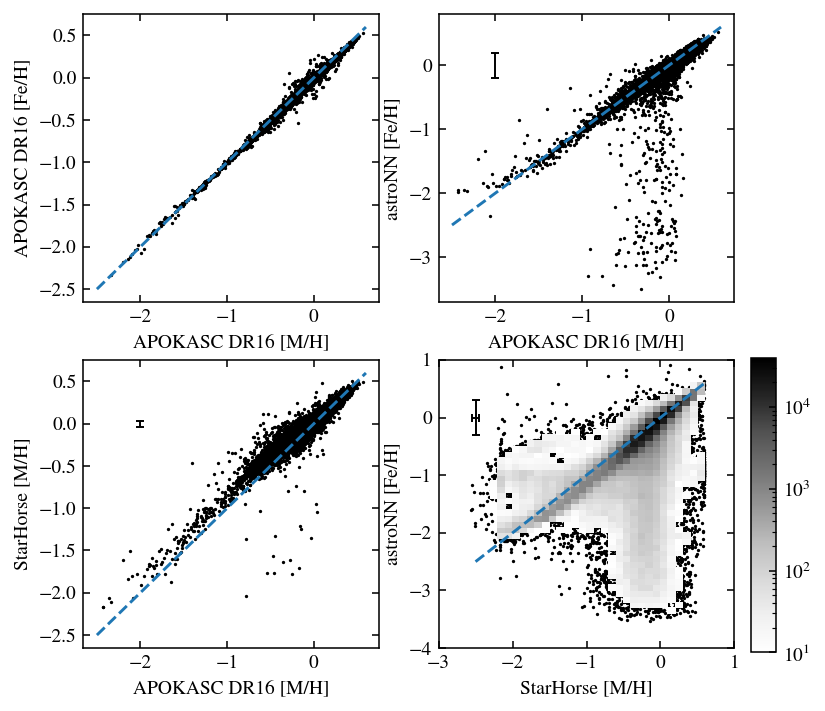

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(6, 6))

# APOKASC Fe/H vs M/H
ax = axs[0, 0]
metals = stellar_params[(pd.notna(stellar_params['DR16_M_H_COR'])) & (pd.notna(stellar_params['DR16_FE_H']))]
ax.scatter(metals['DR16_M_H_COR'], metals['DR16_FE_H'], c='k', s=.5)
# Reported errors are too small to be noticeable
ax.plot([-2.5, 0.6], [-2.5, 0.6], linestyle='--')
ax.set_xlabel('APOKASC DR16 [M/H]')
ax.set_ylabel('APOKASC DR16 [Fe/H]')

# APOKASC vs astroNN
ax = axs[0, 1]
metals = stellar_params[(pd.notna(stellar_params['ASTRONN_FE_H'])) & (pd.notna(stellar_params['DR16_M_H_COR']))]
ax.scatter(metals['DR16_M_H_COR'], metals['ASTRONN_FE_H'], c='k', s=.5)
ax.plot([-2.5, 0.6], [-2.5, 0.6], linestyle='--')
ax.errorbar(-2, 0, 
#             xerr=rms(metals['DR16M_H_COR_ERR']), 
            yerr=rms(metals['ASTRONN_FE_H_ERR']), 
            color='k', capsize=2, elinewidth=1)
# Weirdos cut: APOKASC - astroNN >= 0.5
# ax.plot([-0.7, 0.2], [-1.2, -0.3], linestyle='-', color='r')
ax.set_xlabel('APOKASC DR16 [M/H]')
ax.set_ylabel('astroNN [Fe/H]')

# APOKASC vs StarHorse
ax = axs[1, 0]
metals = stellar_params[(pd.notna(stellar_params['STARHORSE_M_H'])) & (pd.notna(stellar_params['DR16_M_H_COR']))]
ax.scatter(metals['DR16_M_H_COR'], metals['STARHORSE_M_H'], c='k', s=.5)
ax.plot([-2.5, 0.6], [-2.5, 0.6], linestyle='--')
ax.errorbar(-2, 0, 
#             xerr=rms(metals['DR16_M_H_COR_ERR']),
            yerr=[[rms(metals['STARHORSE_M_H_MERR'])], [rms(metals['STARHORSE_M_H_PERR'])]],
            color='k', capsize=2, elinewidth=1)
ax.set_xlabel('APOKASC DR16 [M/H]')
ax.set_ylabel('StarHorse [M/H]')

ax = axs[1, 1]
metals = stellar_params[(pd.notna(stellar_params['ASTRONN_FE_H'])) & (pd.notna(stellar_params['STARHORSE_M_H']))]
metals.drop(metals[(metals['ASTRONN_FE_H'] < -4) | (metals['ASTRONN_FE_H'] > 1)].index, inplace=True)
metals.drop(metals[metals['ASTRONN_FE_H_ERR'] > 5].index, inplace=True)
ax.scatter(metals['STARHORSE_M_H'], metals['ASTRONN_FE_H'], c='k', s=.5)
hist, xedges, yedges, im = ax.hist2d(metals['STARHORSE_M_H'], metals['ASTRONN_FE_H'], 
                                     bins=[np.arange(-3, 1.1, 0.1), np.arange(-4, 1.1, 0.1)], 
                                     cmap='Greys', norm=colors.LogNorm(), cmin=10)
ax.plot([-2.5, 0.6], [-2.5, 0.6], linestyle='--')
ax.errorbar(-2.5, 0, 
            xerr=[[rms(metals['STARHORSE_M_H_MERR'])], [rms(metals['STARHORSE_M_H_PERR'])]],
            yerr=rms(metals['ASTRONN_FE_H_ERR']),
            color='k', capsize=2, elinewidth=1)
plt.subplots_adjust(right=0.9)
cax = plt.axes([0.92, 0.12, 0.03, 0.35])
plt.colorbar(im, cax=cax)
ax.set_xlabel('StarHorse [M/H]')
ax.set_ylabel('astroNN [Fe/H]')

plt.show()

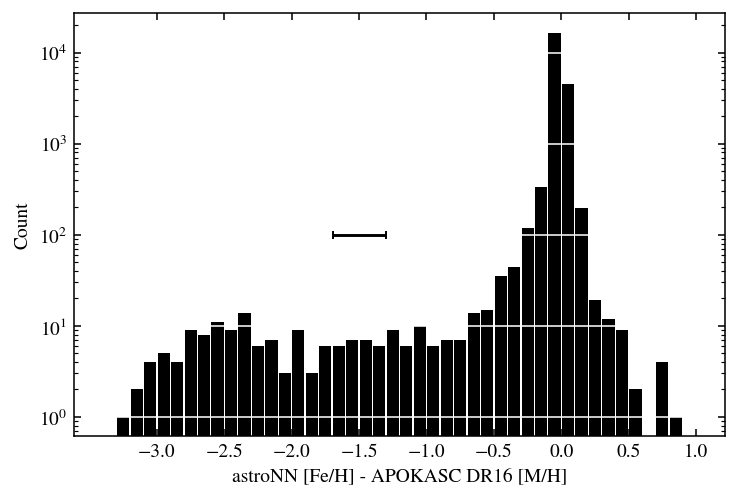

In [34]:
# Isolate astroNN outliers
metals = stellar_params[(pd.notna(stellar_params['ASTRONN_FE_H'])) & (pd.notna(stellar_params['DR16_M_H_COR']))]
fe_diff = metals['ASTRONN_FE_H'] - metals['DR16_M_H_COR']
fe_diff_err = quad_add(rms(metals['ASTRONN_FE_H_ERR']), rms(metals['DR16_M_H_COR_ERR']))

fig, ax = plt.subplots()

xmin = -3.4
xmax = 1
xstep = 0.1
bins = np.arange(xmin, xmax+xstep, xstep)
y, x, _ = ax.hist(fe_diff, color='k', bins=bins, rwidth=0.9)
ax.errorbar(-1.5, 100, xerr=fe_diff_err, c='k', capsize=2)
ax.grid(which='major', axis='y', color='w')
ax.set_yscale('log')
ax.set_xlabel('astroNN [Fe/H] - APOKASC DR16 [M/H]')
ax.set_ylabel('Count')
ax.set_xticks(np.arange(-3, 1.5, 0.5))
plt.show()

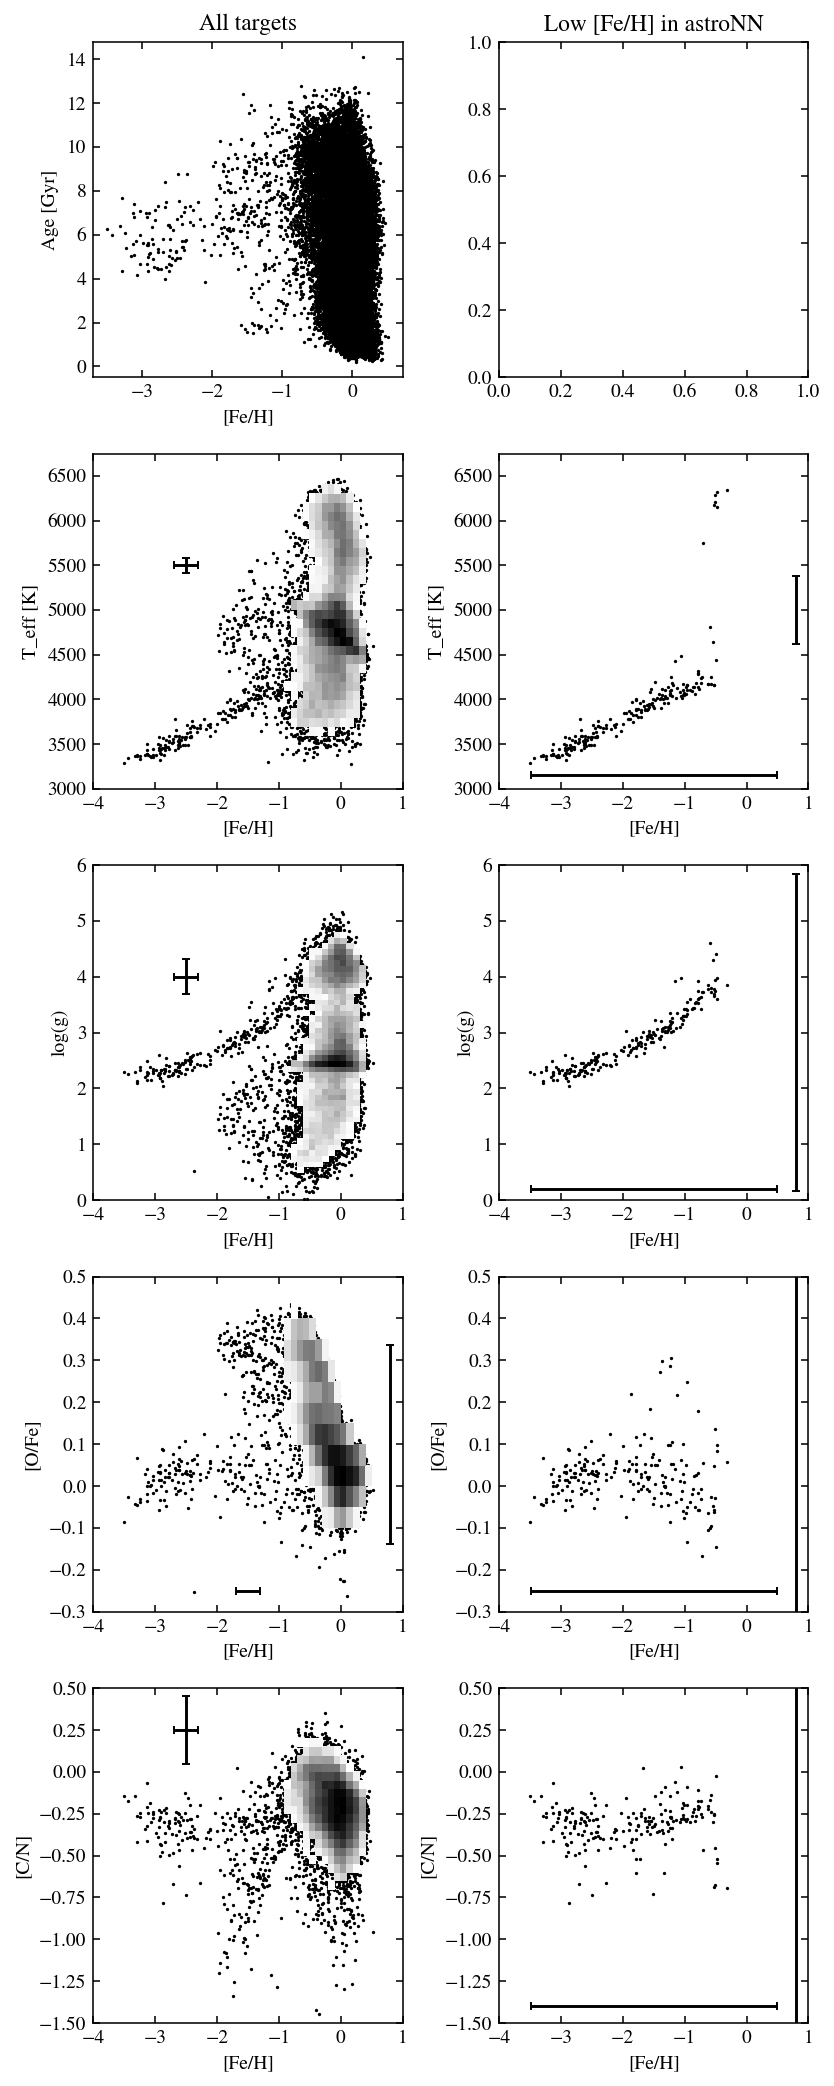

In [107]:
# Investigate low-[Fe/H] astroNN data

metals = stellar_params[(pd.notna(stellar_params['ASTRONN_FE_H'])) & (pd.notna(stellar_params['DR16_M_H_COR']))]
low_fe = metals[metals['ASTRONN_FE_H'] - metals['DR16_M_H_COR'] < -0.5]

fig, axs = plt.subplots(5, 2, figsize=(6, 15), tight_layout=True)

# Age
ax = axs[0,0]
ax.set_title('All targets')
ax.scatter(metals['ASTRONN_FE_H'], metals['ASTRONN_AGE'], c='k', s=.5)
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('Age [Gyr]')

ax = axs[0,1]
ax.set_title('Low [Fe/H] in astroNN')

# Teff
ax = axs[1,0]
ax.scatter(metals['ASTRONN_FE_H'], metals['ASTRONN_TEFF'], c='k', s=.5)
ax.hist2d(metals['ASTRONN_FE_H'], metals['ASTRONN_TEFF'], 
          bins=[np.arange(-4, 1.1, 0.1), np.arange(3000, 6600, 100)], 
          cmap='Greys', norm=colors.LogNorm(), cmin=10)
ax.errorbar(-2.5, 5500, 
            xerr=rms(metals['ASTRONN_FE_H_ERR']), 
            yerr=rms(metals['ASTRONN_TEFF_ERR']), 
            c='k', capsize=2)
ax.set_xlim((-4, 1))
ax.set_ylim((3000, 6750))
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('T_eff [K]')

ax = axs[1,1]
ax.scatter(low_fe['ASTRONN_FE_H'], low_fe['ASTRONN_TEFF'], c='k', s=.5)
ax.errorbar(-1.5, 3150, 
            xerr=rms(low_fe['ASTRONN_FE_H_ERR']), 
            c='k', capsize=2)
ax.errorbar(0.8, 5000,
            yerr=rms(low_fe['ASTRONN_TEFF_ERR']), 
            c='k', capsize=2)
ax.set_xlim((-4, 1))
ax.set_ylim((3000, 6750))
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('T_eff [K]')

# log(g)
ax = axs[2,0]
ax.scatter(metals['ASTRONN_FE_H'], metals['ASTRONN_LOGG'], c='k', s=.5)
ax.hist2d(metals['ASTRONN_FE_H'], metals['ASTRONN_LOGG'], 
          bins=[np.arange(-4, 1.1, 0.1), np.arange(0, 5.1, 0.1)], 
          cmap='Greys', norm=colors.LogNorm(), cmin=10)
ax.errorbar(-2.5, 4, 
            xerr=rms(metals['ASTRONN_FE_H_ERR']), 
            yerr=rms(metals['ASTRONN_LOGG_ERR']), 
            c='k', capsize=2)
ax.set_xlim((-4, 1))
ax.set_ylim((0, 6))
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('log(g)')

ax = axs[2,1]
ax.scatter(low_fe['ASTRONN_FE_H'], low_fe['ASTRONN_LOGG'], c='k', s=.5)
ax.errorbar(-1.5, 0.2, 
            xerr=rms(low_fe['ASTRONN_FE_H_ERR']), 
            c='k', capsize=2)
ax.errorbar(0.8, 3,
            yerr=rms(low_fe['ASTRONN_LOGG_ERR']),
            c='k', capsize=2)
ax.set_xlim((-4, 1))
ax.set_ylim((0, 6))
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('log(g)')

# [O/Fe]
ax = axs[3,0]
ax.scatter(metals['ASTRONN_FE_H'], metals['ASTRONN_O_FE'], c='k', s=.5)
ax.hist2d(metals['ASTRONN_FE_H'], metals['ASTRONN_O_FE'], 
          bins=[np.arange(-4, 1.1, 0.1), np.arange(-0.3, 0.55, 0.05)],
          cmap='Greys', norm=colors.LogNorm(), cmin=10)
ax.errorbar(-1.5, -0.25, 
            xerr=rms(metals['ASTRONN_FE_H_ERR']),  
            c='k', capsize=2)
ax.errorbar(0.8, 0.1, 
            yerr=rms(metals['ASTRONN_O_FE_ERR']), 
            c='k', capsize=2)
ax.set_xlim((-4, 1))
ax.set_ylim((-0.3, 0.5))
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('[O/Fe]')

ax = axs[3,1]
ax.scatter(low_fe['ASTRONN_FE_H'], low_fe['ASTRONN_O_FE'], c='k', s=.5)
ax.errorbar(-1.5, -0.25, 
            xerr=rms(low_fe['ASTRONN_FE_H_ERR']), 
            c='k', capsize=2)
ax.errorbar(0.8, 0.1,
            yerr=rms(low_fe['ASTRONN_O_FE_ERR']),
            c='k', capsize=2)
ax.set_xlim((-4, 1))
ax.set_ylim((-0.3, 0.5))
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('[O/Fe]')

# [C/N]
ax = axs[4,0]
ax.scatter(metals['ASTRONN_FE_H'], metals['ASTRONN_C_N'], c='k', s=.5)
ax.hist2d(metals['ASTRONN_FE_H'], metals['ASTRONN_C_N'], 
          bins=[np.arange(-4, 1.1, 0.1), np.arange(-1.5, 0.55, 0.05)], 
          cmap='Greys', norm=colors.LogNorm(), cmin=10)
ax.errorbar(-2.5, 0.25, 
            xerr=rms(metals['ASTRONN_FE_H_ERR']), 
            yerr=rms(metals['ASTRONN_C_N_ERR']), 
            c='k', capsize=2)
ax.set_xlim((-4, 1))
ax.set_ylim((-1.5, 0.5))
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('[C/N]')

ax = axs[4,1]
ax.scatter(low_fe['ASTRONN_FE_H'], low_fe['ASTRONN_C_N'], c='k', s=.5)
ax.errorbar(-1.5, -1.4, 
            xerr=rms(low_fe['ASTRONN_FE_H_ERR']), 
            c='k', capsize=2)
ax.errorbar(0.8, -0.5,
            yerr=rms(low_fe['ASTRONN_C_N_ERR']),
            c='k', capsize=2)
ax.set_xlim((-4, 1))
ax.set_ylim((-1.5, 0.5))
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('[C/N]')

plt.show()

### Age - alpha relation

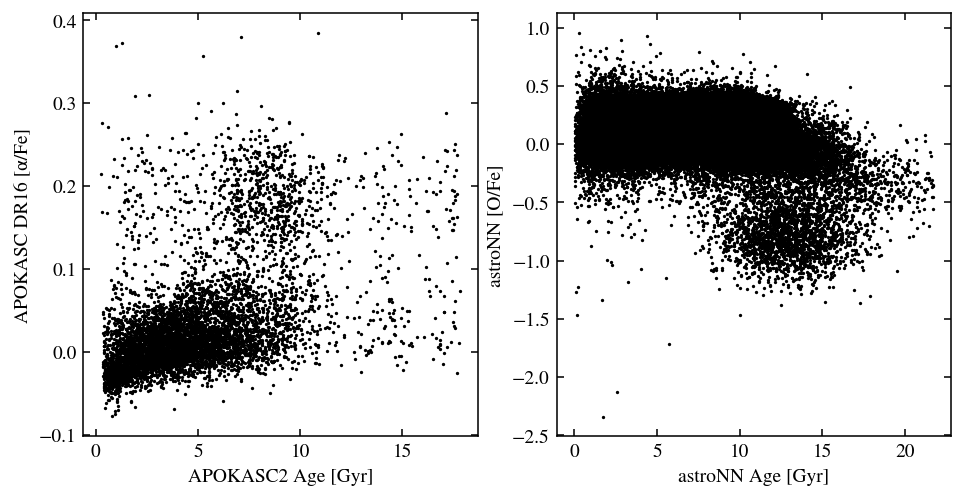

In [155]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
# APOKASC data
ax = axs[0]
age_alpha = stellar_params[(pd.notna(stellar_params['APOKASC2_AGE'])) & (pd.notna(stellar_params['DR16_ALP_M_COR']))]
ax.scatter(age_alpha['APOKASC2_AGE'], age_alpha['DR16_ALP_M_COR'], c='k', s=.5)
ax.set_xlabel('APOKASC2 Age [Gyr]')
ax.set_ylabel('APOKASC DR16 [α/Fe]')

# astroNN data
ax = axs[1]
age_alpha = stellar_params[(pd.notna(stellar_params['ASTRONN_AGE'])) & (pd.notna(stellar_params['ASTRONN_O_FE']))]
age_alpha.drop(age_alpha[(age_alpha['ASTRONN_O_FE'] < -3) | (age_alpha['ASTRONN_O_FE'] > 1)].index, inplace=True)
ax.scatter(age_alpha['ASTRONN_AGE'], age_alpha['ASTRONN_O_FE'], c='k', s=.5)
ax.set_xlabel('astroNN Age [Gyr]')
ax.set_ylabel('astroNN [O/Fe]')
plt.show()

### Comment

This doesn't look right... astroNN O abundances look opposite what they should be.